Exploratory Data Analysis of Data set 2

In [ ]:
# data processing modules
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
# modules used in time series calculations
import time
import datetime
from math import log, floor
from tqdm.notebook import tqdm as tqdm
# plotting modules
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import math
from statsmodels.robust import mad
import scipy
import statsmodels
import statsmodels.api as sm
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

print("Before, figure default size is: ", plt.rcParams["figure.figsize"])
plt.rcParams["figure.figsize"] = (20,10)
print("After, figure default size is: ", plt.rcParams["figure.figsize"])

Before, figure default size is:  [6.0, 4.0]
After, figure default size is:  [20.0, 10.0]


Dowload the dataset

In [ ]:
# data set download to vm
!wget https://github.com/bhanusumanth/ai-sales-predict-dataset/raw/master/CECS551_dataset_02.zip

--2022-12-05 03:52:38--  https://github.com/bhanusumanth/ai-sales-predict-dataset/raw/master/CECS551_dataset_02.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/CECS551_dataset_02.zip [following]
--2022-12-05 03:52:38--  https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/CECS551_dataset_02.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70757765 (67M) [application/zip]
Saving to: ‘CECS551_dataset_02.zip’

CECS551_dataset_02. 100%[===================>]  67.48M   157MB/s    in 0.4s    

2022-12-05 03:52:42 (157 MB/s) -

In [ ]:
# download the weather data
# obtained this data from https://www.noaa.gov/
!wget https://github.com/bhanusumanth/ai-sales-predict-dataset/raw/master/weather.csv

--2022-12-05 03:52:42--  https://github.com/bhanusumanth/ai-sales-predict-dataset/raw/master/weather.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/weather.csv [following]
--2022-12-05 03:52:42--  https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1488939 (1.4M) [text/plain]
Saving to: ‘weather.csv’

weather.csv         100%[===================>]   1.42M  --.-KB/s    in 0.02s   

2022-12-05 03:52:42 (67.7 MB/s) - ‘weather.csv’ saved [1488939/1488939]



In [ ]:
!unzip -q CECS551_dataset_02.zip

In [ ]:
# load to pandas dataframes
sales_raw = pd.read_csv("/content/CECS551_dataset_02/Tableau/tableau_sales_train_evaluation_365_days.csv")
sell_prices_raw = pd.read_csv("/content/CECS551_dataset_02/Tableau/sell_prices.csv")
weather_raw = pd.read_csv('/content/weather.csv')
calendar_raw = pd.read_csv("/content/CECS551_dataset_02/Tableau/calendar.csv")


Before Downcasting

In [ ]:
sales_bd = np.round(sales_raw.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar_raw.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(sell_prices_raw.memory_usage().sum()/(1024*1024),1)
weather_bd =  np.round(weather_raw.memory_usage().sum()/(1024*1024),1)

## Downcasting
Reduce the data frame sizes with out altering the values.
https://pypi.org/project/pandas-downcast/ API Reference

In [ ]:
# Apply downcasting to dataset, shrinking the data set to save memory in future computations. Helper function to to downcasting to dataframes
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        # check if the type us an integer
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        # check if the type us an floating number
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            # check if the type us an date type
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                # treat it as categorical value
                df[cols[i]] = df[cols[i]].astype('category')
    return df


In [ ]:
# downcast the data
sales = downcast(sales_raw)
sell_prices = downcast(sell_prices_raw)
calendar = downcast(calendar_raw)
weather = downcast(weather_raw)

<ipython-input-9-e0a792e434d0>:24: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif t == np.object:


After Downcasting

In [ ]:
sales_ad = np.round(sales_raw.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar_raw.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(sell_prices_raw.memory_usage().sum()/(1024*1024),1)
weather_ad =  np.round(weather_raw.memory_usage().sum()/(1024*1024),1)

In [ ]:
dic = {'DataFrame':['sales','calendar','sell_prices','weather'],
       'Before downcasting':[sales_bd,calendar_bd,prices_bd,weather_bd],
       'After downcasting':[sales_ad,calendar_ad,prices_ad,weather_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

Lets take a look into the data

In [ ]:
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_356  d_357  d_358  d_359  d_360  d_361  \
0       CA    0    0    0    0  ...      0      0      0      0      0      0   
1       CA    0    0    0    0  ...      0      0      0      1      0      0   
2       CA    0    0    0    0  ...      0      0      0      0      0      0   
3       CA    0    0    0    0  ...      0      1      1      8      1      3   
4       CA    0    0    0    0  ...      1      0      0      0      0      0   

   d_362  d_363  d_364  d_365  
0      0      0      0      0  
1      1      1      0      0  
2      0      0      0      0  
3      0      1      2      3  
4      0      0      0      0  

[5 rows x 371 columns]

Sales data is horizantally huge and each day sales are in columns. But, Prices data has day sales in records. So, We need to cut down the horizantal table into set of records for each day into vertical table. It is also called as **melting the data**.
API Reference - https://pandas.pydata.org/docs/reference/api/pandas.melt.html

In [ ]:
# Melting the data
sales = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id','state_id'], var_name='d', value_name='sold').dropna()

In [ ]:
# Lets look into the transformed table
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sold  
0       CA  d_1     0  
1       CA  d_1     0  
2       CA  d_1     0  
3       CA  d_1     0  
4       CA  d_1     0

Table has been melted now, Lets Look into other data frames

In [ ]:
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325    9.578125
1     CA_1  HOBBIES_1_001     11326    9.578125
2     CA_1  HOBBIES_1_001     11327    8.257812
3     CA_1  HOBBIES_1_001     11328    8.257812
4     CA_1  HOBBIES_1_001     11329    8.257812

In [ ]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0 2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1 2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2 2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3 2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4 2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

Lets Ignore climate information for now and focus on other data for EDA

Joining Sales table with Calendar table (LEFT JOIN) with respect to Day column (since we have melted days coulmns to single one)

In [ ]:
df = pd.merge(sales, calendar,how = "left",on = 'd')

Similarly Lets join the result with price data, based on store_id, item_id and week string. Using Left join.

In [ ]:
df = pd.merge(df, sell_prices, how = 'left', on = ['store_id','item_id','wm_yr_wk'])

In [ ]:
# lets look at df after all joins
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sold       date  wm_yr_wk  ... month  year  event_name_1  \
0       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   
1       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   
2       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   
3       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   
4       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   

   event_type_1 event_name_2 event_type_2 snap_CA snap_TX  snap_WI  sell_price  
0           NaN          NaN          NaN       0       0        0         NaN  
1           NaN          NaN          NaN       0       0        0         NaN  
2           NaN          NaN          NaN       0       0        0         NaN  
3           NaN          NaN          NaN       0       0        0         NaN  
4           NaN          NaN          NaN       0       0        0         NaN  

[5 rows x 22 columns]

Checking for null values

In [ ]:
calendar.isnull().sum(axis = 0)

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [ ]:
sell_prices.isnull().sum(axis=0)

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [ ]:
sales.isnull().sum(axis=0)

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
d           0
sold        0
dtype: int64

No null values in cales and prices data set

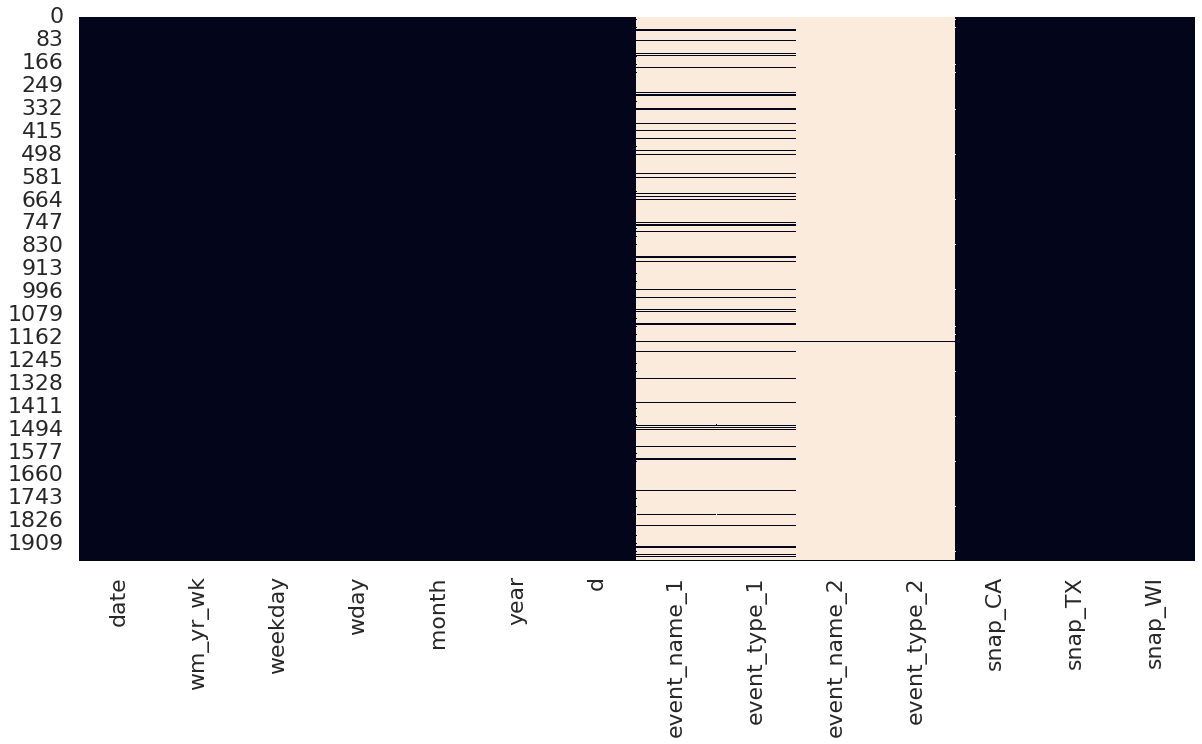

In [ ]:
sns.heatmap(calendar.isnull(), cbar=False)

## Plotting the total products sold over time for each store



In [ ]:
# grouping sales by store to create a time series plot
grouped = df.groupby(['store_id','date']).sum()
grouped.reset_index( inplace=True)

In [ ]:
grouped.head()

store_id       date    sold    wm_yr_wk     wday   month       year  \
0     CA_1 2011-01-29  4337.0  33846949.0   3049.0  3049.0  6131539.0   
1     CA_1 2011-01-30  4155.0  33846949.0   6098.0  3049.0  6131539.0   
2     CA_1 2011-01-31  2816.0  33846949.0   9147.0  3049.0  6131539.0   
3     CA_1 2011-02-01  3051.0  33846949.0  12196.0  6098.0  6131539.0   
4     CA_1 2011-02-02  2630.0  33846949.0  15245.0  6098.0  6131539.0   

   snap_CA  snap_TX  snap_WI  sell_price  
0      0.0      0.0      0.0      4912.0  
1      0.0      0.0      0.0      4912.0  
2      0.0      0.0      0.0      4912.0  
3   3049.0   3049.0      0.0      4912.0  
4   3049.0      0.0   3049.0      4912.0

In [ ]:
# creating the plot
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'store_id' ,title='Store level unit sales distribution over Time')
fig.update_layout(autosize=True)
fig.show()

In [ ]:
# Creating SUb plots for each store over unit sales sold
fig = make_subplots(rows=3, cols=4,subplot_titles=('CA_1',
 'CA_2',
 'CA_3',
 'CA_4',
 'TX_1',
 'TX_2',
 'TX_3','',
 'WI_1',
 'WI_2',
 'WI_3' ))

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_1']['sold'])), row = 1, col=1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_2']['sold'])), row = 1, col=2 )


fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_3']['sold'])), row = 1, col=3 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_4']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_4']['sold'])), row = 1, col=4 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_1']['sold'])), row = 2, col=1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_2']['sold'])), row = 2, col=2 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_3']['sold'])), row = 2, col=3 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_1']['sold'])), row = 3, col = 1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_2']['sold'])), row = 3, col=2 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_3']['sold'])), row = 3, col=3 )


fig.update_layout(height=800, width=2000, title_text="Store level unit sales distribution over time - sub plot")
fig.show()

Total unit sales over time for each state

In [ ]:
# Group data to create plot
grouped = df.groupby(['state_id','date']).sum()
grouped.reset_index( inplace=True)

In [ ]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'state_id' ,title='Total Unit sales for each state over time ')
fig.update_layout(width=1080, height=500)
fig.show()

Total unit sales over time for each category

In [ ]:
# group data by category
grouped = df.groupby(['cat_id','date']).sum()
grouped.reset_index( inplace=True)

In [ ]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'cat_id' ,title='Total unit sales over time for each category')
fig.update_layout(width=1000, height=400)
fig.show()

Total Revenue generated for each state

In [ ]:
# computing revenue by using units sold * price of each unit
df['revenue'] = df['sold'] * df['sell_price']

In [ ]:
# grouping to create revenue plots
grouped = df.groupby(['store_id','date']).sum()
grouped.reset_index( inplace=True)

In [ ]:
fig = px.line(grouped ,x = 'date', y = 'revenue',color = 'store_id' ,title='Total revenue generated over time from all the sales for all the stores')
fig.update_layout(autosize=True)
fig.show()

Creating subplots of total revenue generated for each store

In [ ]:
fig = make_subplots(rows=3, cols=4,subplot_titles=('CA_1',
 'CA_2',
 'CA_3',
 'CA_4',
 'TX_1',
 'TX_2',
 'TX_3','',
 'WI_1',
 'WI_2',
 'WI_3' ))

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_1']['revenue'])), row = 1, col=1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_2']['revenue'])), row = 1, col=2 )


fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_3']['revenue'])), row = 1, col=3 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_4']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_4']['revenue'])), row = 1, col=4 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_1']['revenue'])), row = 2, col=1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_2']['revenue'])), row = 2, col=2 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_3']['revenue'])), row = 2, col=3 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_1']['revenue'])), row = 3, col = 1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_2']['revenue'])), row = 3, col=2 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_3']['revenue'])), row = 3, col=3 )


fig.update_layout(height=800, width=2000, title_text="Total revenue generated over time per store")
fig.show()

Total Unit sales for each category - Bar plot

In [ ]:
grouped = df.groupby(['store_id','cat_id'], as_index=False).sum().dropna()
x_axis = grouped['store_id'].unique()

In [ ]:

fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS',text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold']
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES',text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Total Unit Sales for each store and each category combined')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(autosize=True)
fig.show()

Total unit sales in each state for each category

In [ ]:
grouped = df.groupby(['state_id','cat_id'], as_index=False).sum().dropna()
x_axis = grouped['state_id'].unique()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS',text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold']
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES', text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Total unit sales in each state for each category')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(width=900, height=500)
fig.show()

Price distribution of different categories in all stores

In [ ]:
grouped = df.groupby(['store_id','cat_id','item_id'], as_index=False)['sell_price'].mean()
# dropping missing values
grouped.dropna().head()

store_id cat_id      item_id  sell_price
0     CA_1  FOODS  FOODS_1_001    2.000000
1     CA_1  FOODS  FOODS_1_002    8.187500
2     CA_1  FOODS  FOODS_1_003    2.880859
4     CA_1  FOODS  FOODS_1_005    3.089844
5     CA_1  FOODS  FOODS_1_006    2.037109

In [ ]:
fig = px.box(grouped, x="store_id", y="sell_price", color="cat_id")
fig.update_layout(title_text='Price distribution of different categories in all stores')
fig.show()

Total unit sales for all subcategories of items per store

In [ ]:
grouped = df.groupby(['store_id','dept_id'], as_index=False)['sold'].sum()
# dropping missing records for plot
grouped.dropna().head()

store_id    dept_id      sold
0     CA_1    FOODS_1   75971.0
1     CA_1    FOODS_2  165121.0
2     CA_1    FOODS_3  585131.0
3     CA_1  HOBBIES_1  147371.0
4     CA_1  HOBBIES_2    6415.0

In [ ]:
fig = px.box(grouped, x="dept_id", y="sold")
fig.update_layout(title_text='Total unit sales for all subcategories of items per store',width=900, height=500)
fig.show()

Total Unit sales for each event for all categories

In [ ]:
grouped = df.groupby(['event_name_1','cat_id'], as_index=False)['sold'].sum()
grouped.dropna(inplace=True)

In [ ]:
x_axis = grouped['event_name_1'].unique()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS',text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold']
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES', text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-65 ,width=1500, height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text='Total Unit sales for each event for all categories')
fig.show()

Products sold in SNAP


In [ ]:
df_snap = df.loc[(df['snap_CA'] == 1) | (df['snap_TX'] == 1) | (df['snap_WI'] == 1)]
grouped = df.groupby(['store_id','cat_id'], as_index=False)['sold'].sum()
grouped.dropna(inplace=True)

In [ ]:
x_axis = grouped['store_id'].unique()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS', text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold']
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES', text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45,width=1000, height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text=' Total number of products sold during SNAP in stores')
fig.show()

Products sold on weekdays and weekends

In [ ]:
grouped = df.groupby(['wday','cat_id'], as_index=False)['sold'].sum()
grouped.dropna(inplace=True)
grouped.head()

wday     cat_id       sold
0     1      FOODS  1197319.0
1     1    HOBBIES   184685.0
2     1  HOUSEHOLD   330396.0
3     2      FOODS  1141662.0
4     2    HOBBIES   151401.0

In [ ]:
x_axis = [ 'Saturday', 'Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS', text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],

))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES', text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45,width=1000, height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text='Products sold on Indivial days in a week')
fig.show()

Analysing Events types distribution across the calendar data

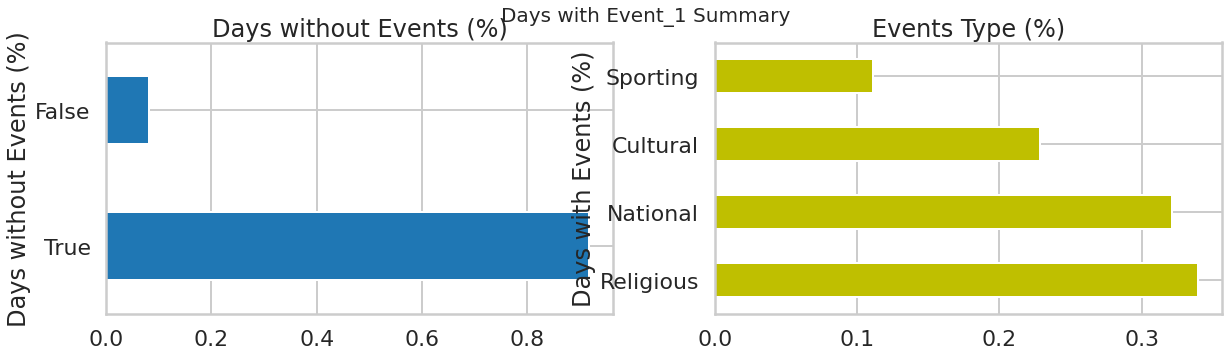

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("Days with Event_1 Summary", fontsize=20)

calendar["event_name_1"].isnull().value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Days without Events (%)", ax=ax1, title="Days without Events (%)")

calendar["event_type_1"].value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Days with Events (%)", ax=ax2, color='y', title="Events Type (%)")

In [ ]:
calendar_e1 = calendar[~calendar["event_name_1"].isnull()]
event1 = pd.DataFrame(calendar_e1[["event_type_1", "event_name_1"]].value_counts())\
                                                                   .reset_index()\
                                                                   .rename({0:"events"}, axis=1)
# subplots and pie charts with plotly
fig = make_subplots(rows=1, cols=2,specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(values=event1['events'], labels=event1['event_type_1']), 1,1)
fig1 = px.sunburst(event1, path=['event_type_1', 'event_name_1'], values='events',
                  color='events',hover_data=['events'], color_continuous_scale='twilight', title = "Events distribution per Event Types")
fig.update_traces(hole=.4, hoverinfo="label+percent+name",textposition='inside', textinfo='percent+label')
fig.update_layout(
    title_text="Events Distribution by Event Type",
    annotations=[dict(text='Event Type', x=0.18, y=0.5, font_size=20, showarrow=False)])
fig.show()
print(event1)
fig1.show()

   event_type_1         event_name_1  events
0      Sporting            SuperBowl       6
1     Religious       Ramadan starts       6
2     Religious            LentStart       6
3      National        PresidentsDay       6
4     Religious            LentWeek2       6
5      National          MemorialDay       6
6     Religious           Pesach End       6
7     Religious            Purim End       6
8      Cultural        ValentinesDay       6
9      Cultural        StPatricksDay       6
10     Cultural         Mother's day       6
11     Sporting         NBAFinalsEnd       6
12     Sporting       NBAFinalsStart       6
13    Religious          Eid al-Fitr       5
14    Religious       OrthodoxEaster       5
15    Religious    OrthodoxChristmas       5
16    Religious            EidAlAdha       5
17     Cultural        Cinco De Mayo       5
18    Religious         Chanukah End       5
19     National          VeteransDay       5
20     Cultural               Easter       5
21     Nat

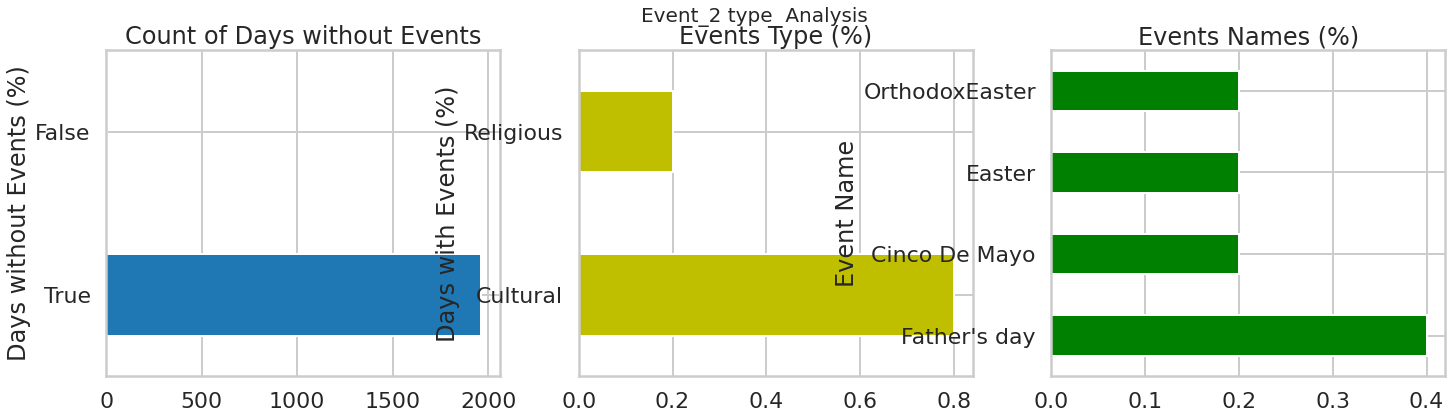

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,6))
fig.suptitle("Event_2 type  Analysis", fontsize=20)
calendar["event_name_2"].isnull().value_counts()\
                                                .plot(kind="barh", xlabel="Days without Events (%)", ax=ax1, title="Count of Days without Events")
calendar["event_type_2"].value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Days with Events (%)", ax=ax2, color='y', title="Events Type (%)")
calendar["event_name_2"].value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Event Name", ax=ax3, color='g', title="Events Names (%)")

In [ ]:
grouped_cat = df.groupby(['state_id', 'cat_id', 'store_id'], as_index=False)['revenue'].sum()
grouped_cat.head()

state_id cat_id store_id      revenue
0       CA  FOODS     CA_1  1998952.875
1       CA  FOODS     CA_2  1269122.000
2       CA  FOODS     CA_3  2740409.750
3       CA  FOODS     CA_4  1051739.125
4       CA  FOODS     TX_1        0.000

In [ ]:
fig = make_subplots(rows=1, cols=3,specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(values=grouped_cat['revenue'], labels=grouped_cat['cat_id']), 1,1)
fig.add_trace(go.Pie(values=grouped_cat['revenue'], labels=grouped_cat['state_id']), 1,2)
fig.add_trace(go.Pie(values=grouped_cat['revenue'], labels=grouped_cat['store_id']), 1,3)

# updating traces and layout

fig.update_traces(hole=.4, hoverinfo="label+percent+name",textposition='inside', textinfo='percent+label')

fig.update_layout(
    title_text="Revenue Distribution across Category ,State and store",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Category', x=0.1, y=0.5, font_size=20, showarrow=False),
                 dict(text='State', x=0.5, y=0.5, font_size=20, showarrow=False), dict(text='Store', x=0.88, y=0.5, font_size=20, showarrow=False)])

fig.show()

Is there seasonality to the sales

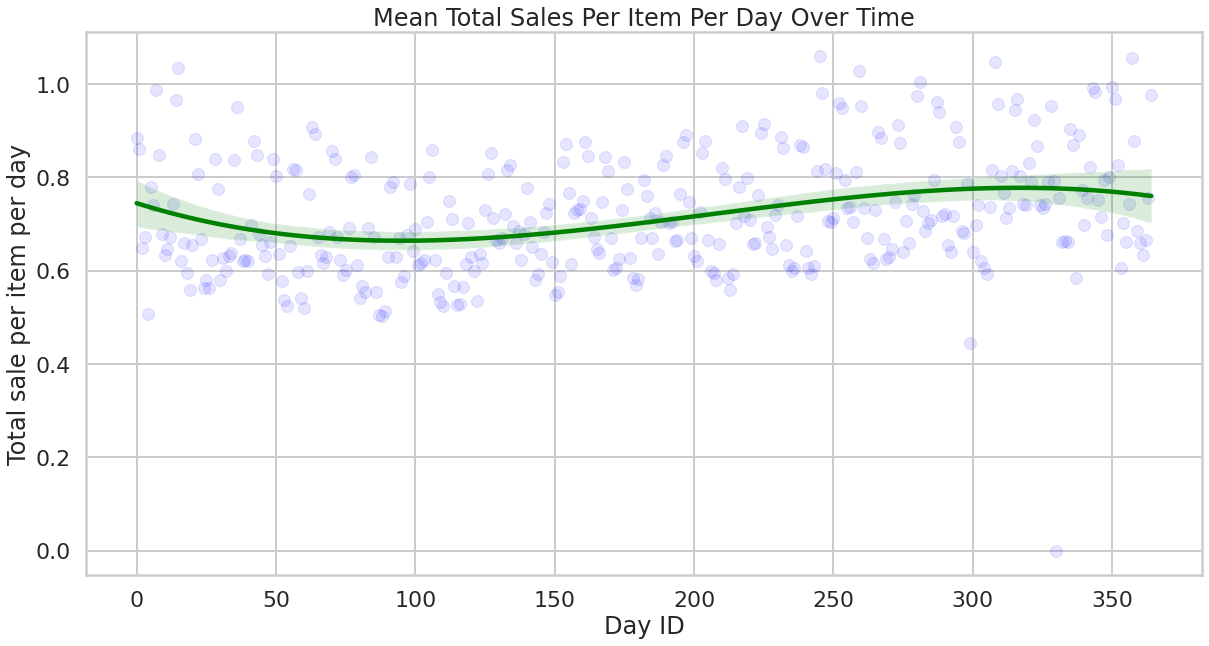

In [ ]:
dept_sales = sales_raw.groupby(['dept_id']).mean().mean()
ax = sns.regplot(x = np.arange(dept_sales.shape[0]), y = dept_sales,
                 scatter_kws = {'color':'blue', 'alpha': 0.1},
                 order = 3, line_kws = {'color':'green'},)

ax.set(title = "Mean Total Sales Per Item Per Day Over Time",
      xlabel = 'Day ID', ylabel = 'Total sale per item per day')

plt.show()

In [ ]:
calendar_raw['date'] = pd.to_datetime(calendar_raw['date'])
#cal_data.set_index('date').index
ids = 8
d_cols = [i for i in sales_raw.columns if 'd_' in i]
print(d_cols)
example = sales_raw.loc[ids][d_cols].reset_index()
example.head()


['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 'd_87', 'd_88', 'd_89', 'd_90', 'd_91', 'd_92', 'd_93', 'd_94', 'd_95', 'd_96', 'd_97', 'd_98', 'd_99', 'd_100', 'd_101', 'd_102', 'd_103', 'd_104', 'd_105', 'd_106', 'd_107', 'd_108', 'd_109', 'd_110', 'd_111', 'd_112', 'd_113', 'd_114', 'd_115', 'd_116', 'd_117', 'd_118', 'd_119', 'd_120', 'd_121', 'd_122', 'd_123', 

index  8
0   d_1  2
1   d_2  0
2   d_3  7
3   d_4  3
4   d_5  0

In [ ]:
example.columns = ['d' , 'sales']
example = example.set_index('d').merge(calendar_raw.set_index('d')['date'], left_index=True, right_index=True)
example = example.set_index('date')

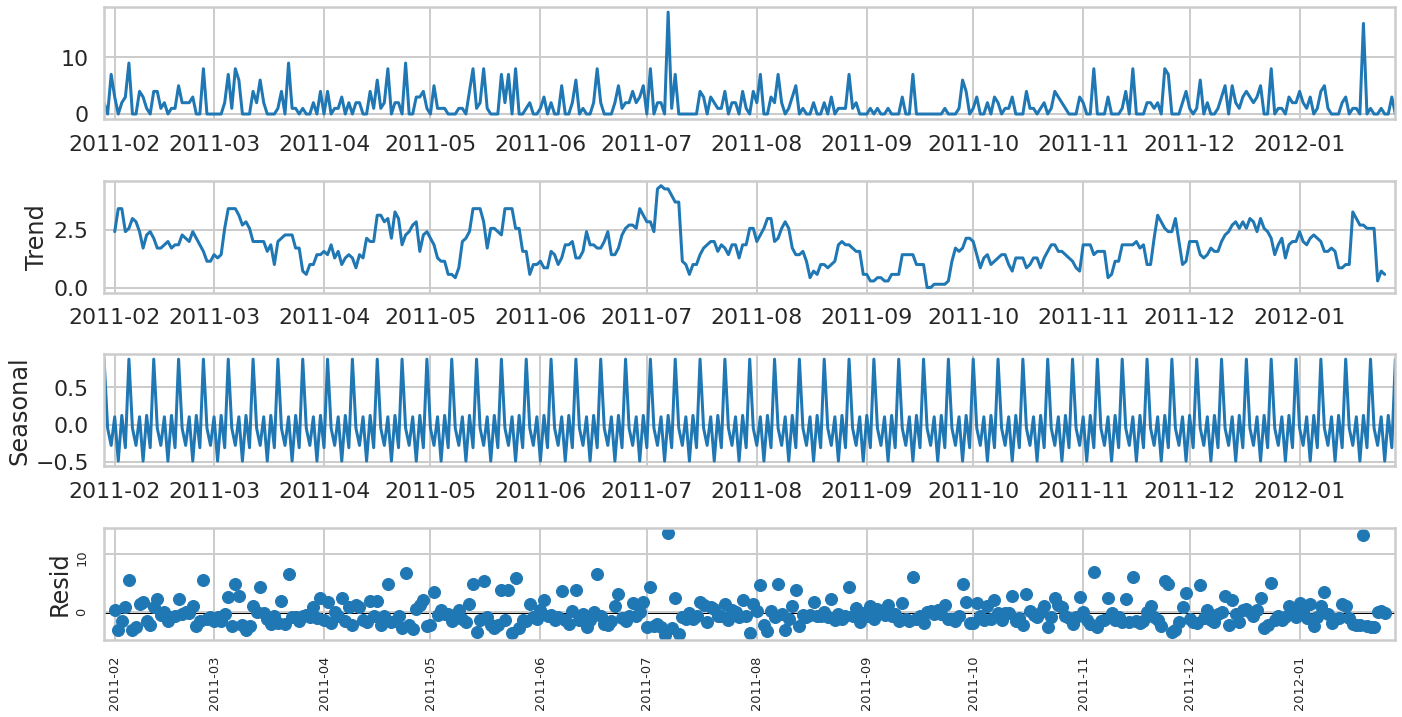

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(example, model='additive', period=7)
from matplotlib.pyplot import figure



result.plot()
plt.xticks(size = 13, rotation=90)
plt.yticks(size = 13, rotation=90)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')


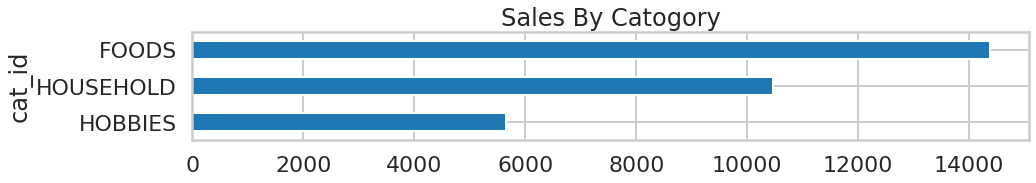

In [ ]:
sales_raw.groupby('cat_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,2), title='Sales By Catogory',width=0.5)
plt.show()

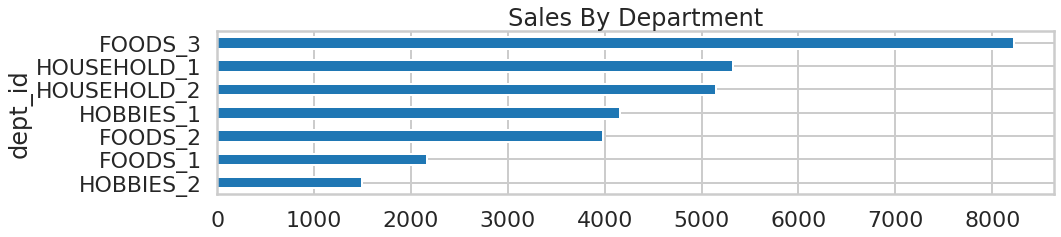

In [ ]:
#Sales By Department
sales_raw.groupby('dept_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,3), title='Sales By Department')
plt.show()

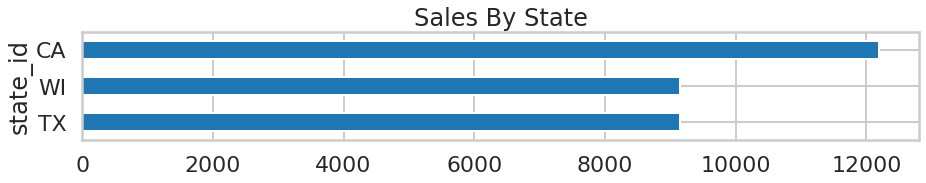

In [ ]:
#Sales By State
sales_raw.groupby('state_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,2), title='Sales By State')
plt.show()

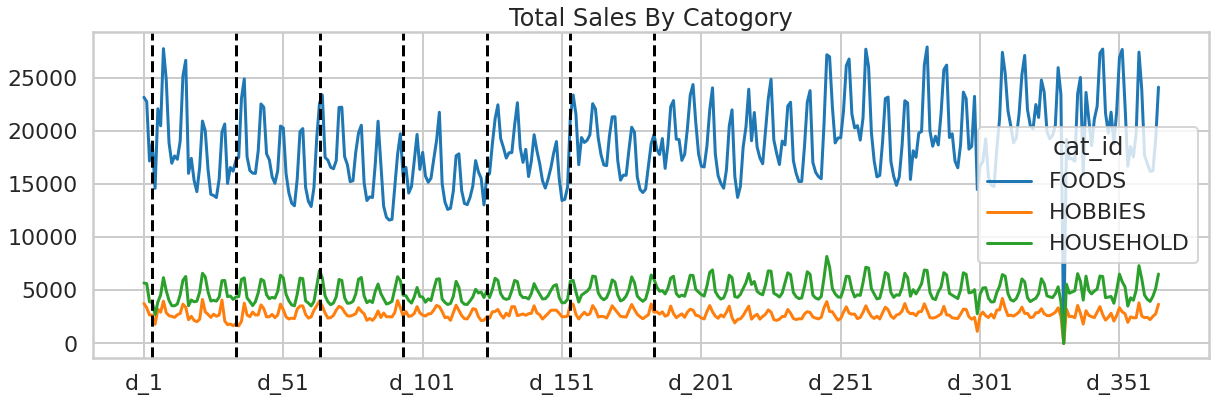

In [ ]:
# to be removed
date_columns = [c for c in sales_raw.columns if 'd_' in c] # select date columns
gouped_by_cat_totals = sales_raw.groupby(['cat_id']).sum().T  #get sum and trasnpose
#print(gouped_by_cat_totals.columns)
gouped_by_cat_totals.plot(figsize=(20,6),title="Total Sales By Catogory")
cal_columns = ['d','month']
monthPosition = np.arange(3,200,30) #Roughly
for xc in monthPosition:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.show()

In [ ]:
cal_columns = ['date','d','month','year','wday','event_type_1','event_type_2']
calendar_selected = calendar[cal_columns].set_index('d')
total_sales_OverCalendar = pd.concat([calendar_selected,gouped_by_cat_totals],axis=1,sort=False)
print(total_sales_OverCalendar['event_type_1'].unique())
print(total_sales_OverCalendar['event_type_2'].unique())
total_sales_OverCalendar.head()


[NaN, 'Cultural', 'National', 'Religious', 'Sporting']
Categories (4, object): ['Cultural', 'National', 'Religious', 'Sporting']
[NaN, 'Religious', 'Cultural']
Categories (2, object): ['Cultural', 'Religious']


date  month  year  wday event_type_1 event_type_2    FOODS  \
d_1    2011-01-29      1  2011     1          NaN          NaN  23178.0   
d_10   2011-02-07      2  2011     3          NaN          NaN  18901.0   
d_100  2011-05-08      5  2011     2     Cultural          NaN  16383.0   
d_1000 2013-10-24     10  2013     6          NaN          NaN      NaN   
d_1001 2013-10-25     10  2013     7          NaN          NaN      NaN   

        HOBBIES  HOUSEHOLD  
d_1      3764.0     5689.0  
d_10     2615.0     4056.0  
d_100    2880.0     4425.0  
d_1000      NaN        NaN  
d_1001      NaN        NaN

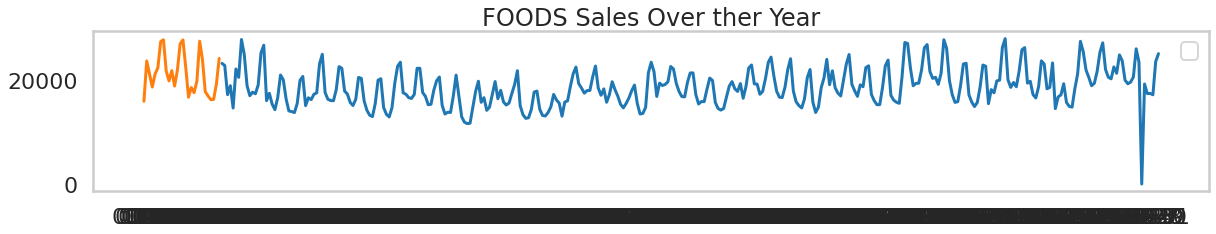

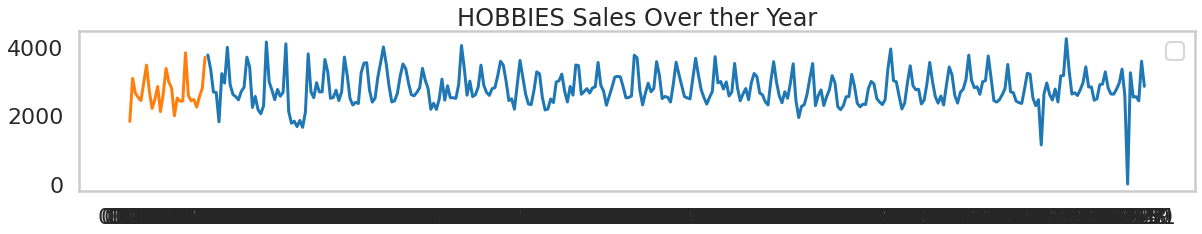

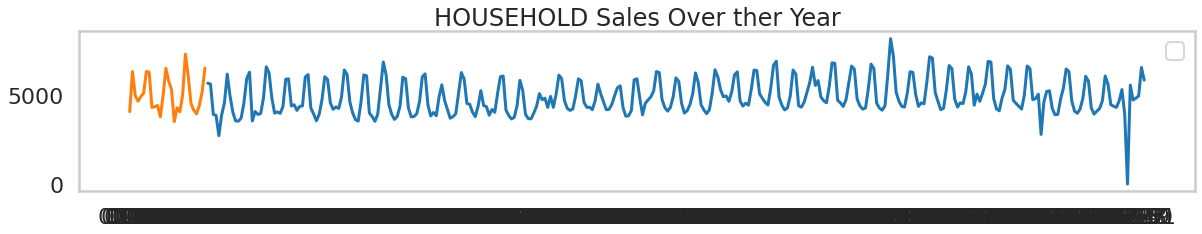

In [ ]:
total_sales_OverCalendar['dayOfYear'] = total_sales_OverCalendar['date'].astype(str).str.slice(5,10)
def plot_pivoted_year(data,name,num):
    plt.figure(figsize=(20,10))
    plt.subplot(3,1,num)
    plt.title(name+" Sales Over ther Year")
    pivoted = data.pivot_table(index='dayOfYear',columns='year',values=name)
    plt.grid()
    plt.plot(pivoted)
    plt.legend()
    plt.show()

plot_pivoted_year(total_sales_OverCalendar,'FOODS',1)
plot_pivoted_year(total_sales_OverCalendar,'HOBBIES',2)
plot_pivoted_year(total_sales_OverCalendar,'HOUSEHOLD',3)

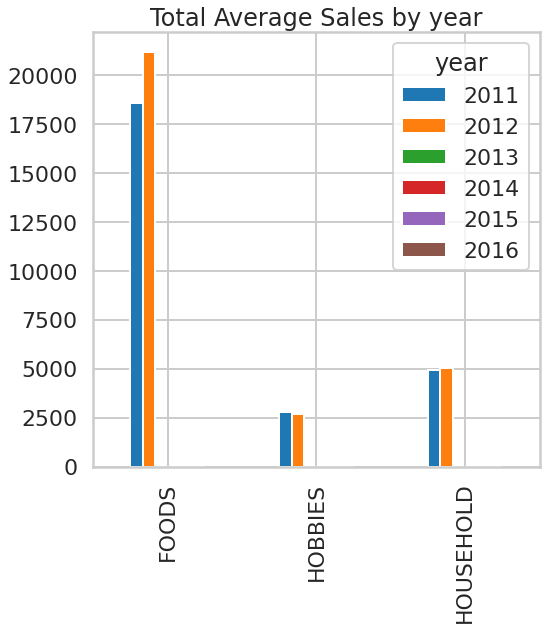

In [ ]:
gouped_yearly = total_sales_OverCalendar.groupby('year')['FOODS','HOBBIES','HOUSEHOLD'].mean().T
gouped_yearly.plot(kind='bar',title='Total Average Sales by year',figsize=(8,8))
plt.show()

Monthly trend analysis

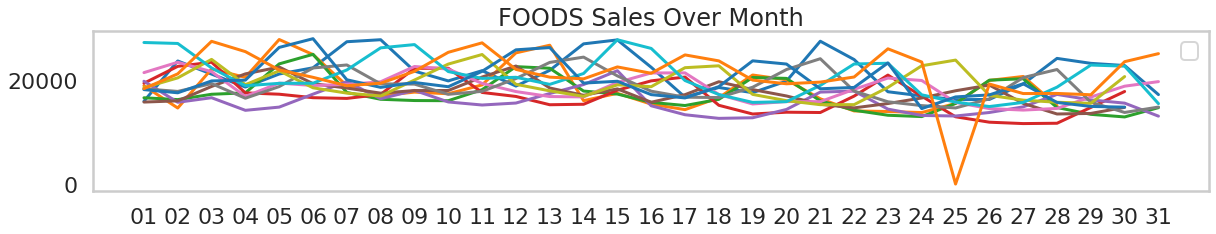

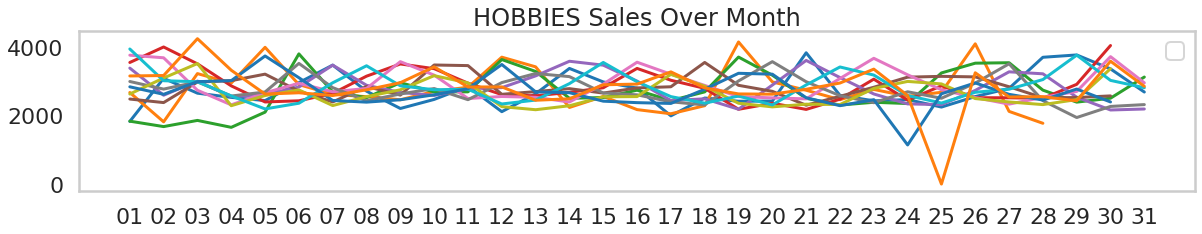

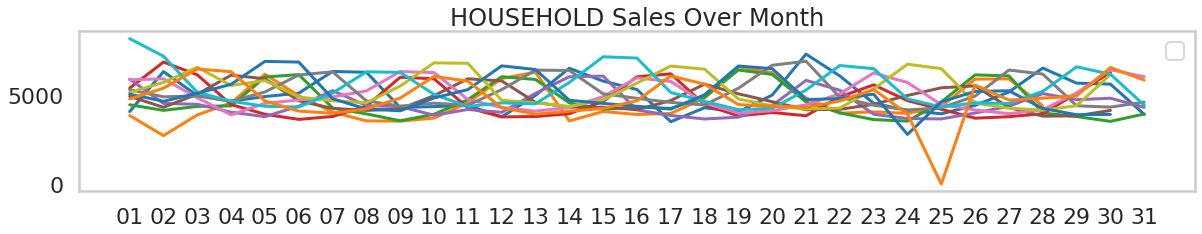

In [ ]:
total_sales_OverCalendar['dayOfMonth'] = total_sales_OverCalendar['date'].astype(str).str.slice(8,10)
def plot_pivoted_month(data,name,num):
    plt.figure(figsize=(20,10))
    plt.subplot(3,1,num)
    plt.title(name+" Sales Over Month")
    pivoted = data.pivot_table(index='dayOfMonth',columns='month',values=name)
    plt.grid()
    plt.plot(pivoted)
    plt.legend()
    plt.show()


plot_pivoted_month(total_sales_OverCalendar,'FOODS',1)
plot_pivoted_month(total_sales_OverCalendar,'HOBBIES',2)
plot_pivoted_month(total_sales_OverCalendar,'HOUSEHOLD',3)


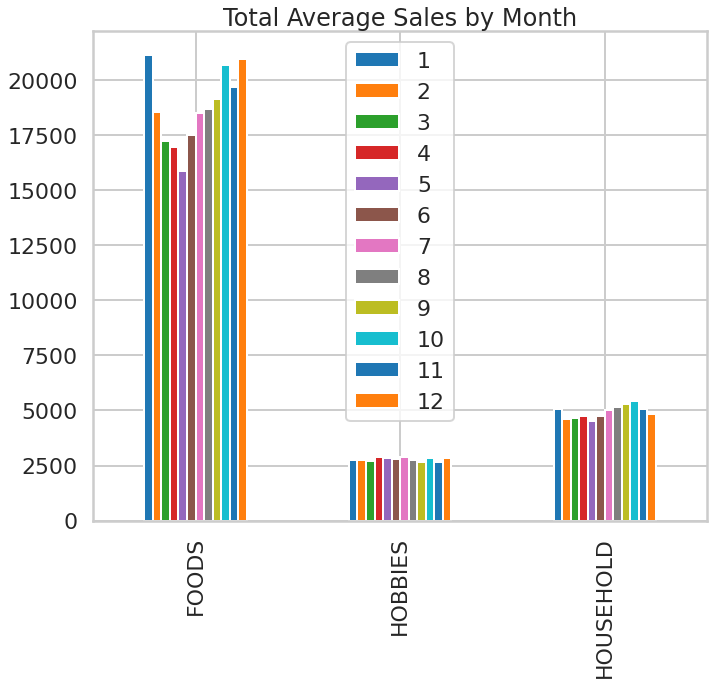

In [ ]:
#Monthly growth
gouped_monthly = total_sales_OverCalendar.groupby('month')['FOODS','HOBBIES','HOUSEHOLD'].mean().T
gouped_monthly.plot(kind='bar',title='Total Average Sales by Month',figsize=(11,9))
plt.legend(loc='best')
plt.show()

Events more like to be annual. We will analyze event effect on Sales on following section



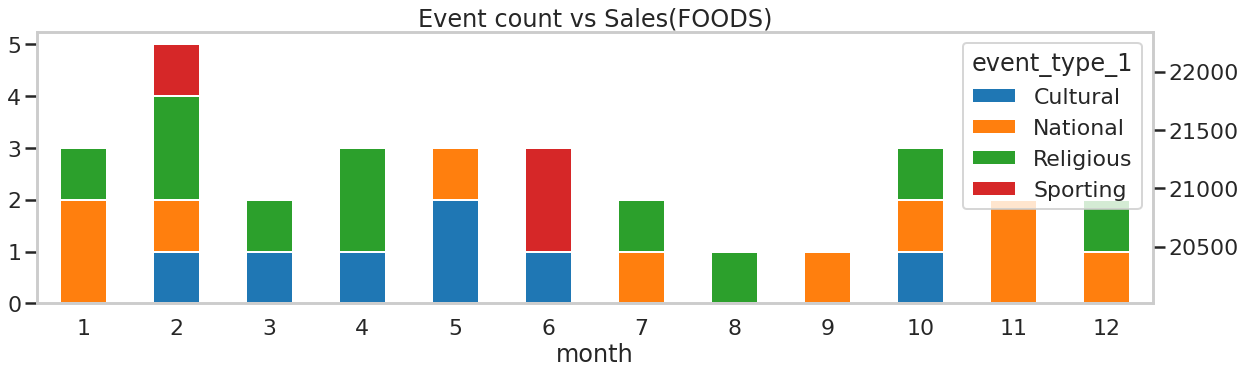

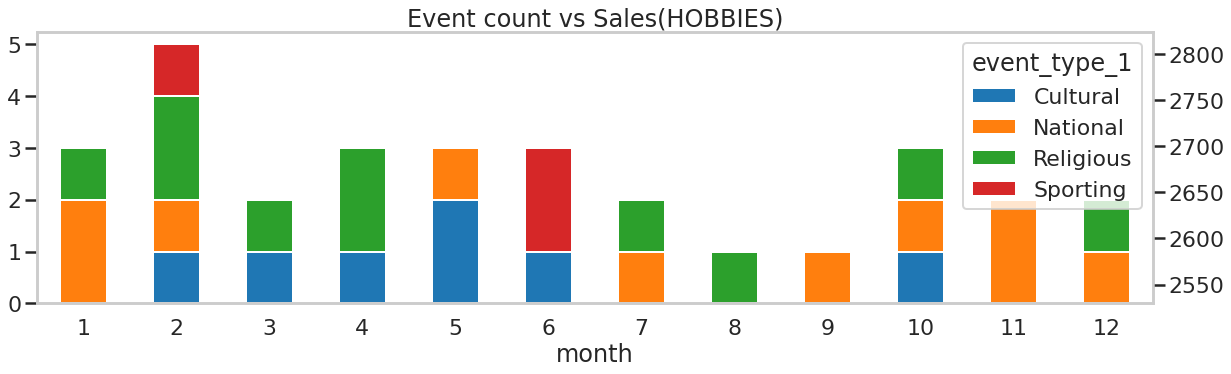

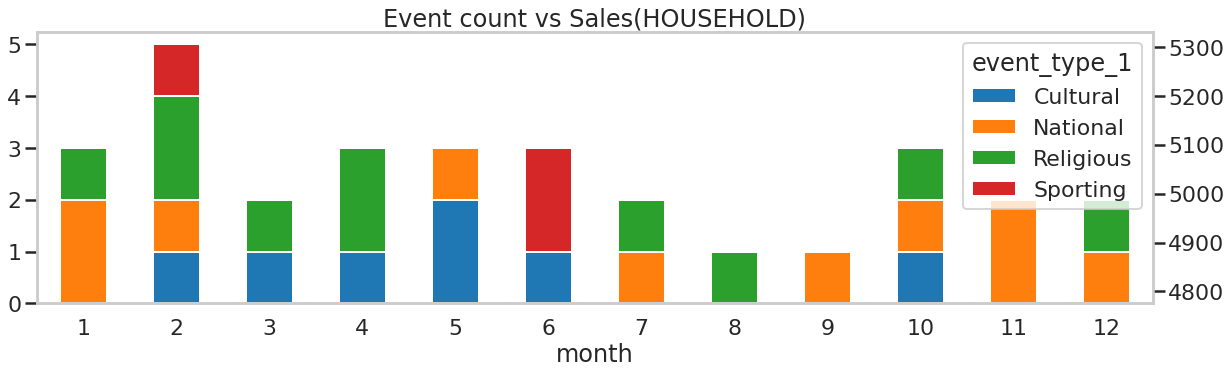

In [ ]:
def plotSalesAndEvents(data,eventData,col_name):
    eventData.plot(kind='bar',figsize=(20,5),title='Event count vs Sales('+col_name+')',stacked=True)
    data[col_name].plot(secondary_y=True,figsize=(20,5),linewidth=4)
    plt.grid()
    plt.show()

def getEventData(data,eventType):
    eventData = data[data[eventType].notnull()].pivot_table(index='month',columns=eventType,values='wday',aggfunc=len)
    eventData = eventData.fillna(0)
    eventData = eventData.reset_index('month')
    eventData = eventData.set_index('month')
    return eventData

#Chose complete year data. 2011 and 2016 we don;t have whole year data.
complete_year_data = total_sales_OverCalendar[ (total_sales_OverCalendar['year']>2011) & (total_sales_OverCalendar['year']<2016)]
gouped_monthly = complete_year_data.groupby('month')['FOODS','HOBBIES','HOUSEHOLD'].mean()
gouped_monthly = gouped_monthly.reset_index('month')
data_2012 = total_sales_OverCalendar[total_sales_OverCalendar['year']==2012]
eventData = getEventData(data_2012,'event_type_1')
plotSalesAndEvents(gouped_monthly,eventData,'FOODS')
plotSalesAndEvents(gouped_monthly,eventData,'HOBBIES')
plotSalesAndEvents(gouped_monthly,eventData,'HOUSEHOLD')

Modeling start with ARIMA


Test Statistic              -6.015566e+00
p-value                      1.536682e-07
#Lags Used                   2.600000e+01
No of Observesations Used    1.942000e+03
Critical Value (1%)         -3.433722e+00
Critical Value (5%)         -2.863029e+00
Critical Value (10%)        -2.567563e+00
dtype: float64


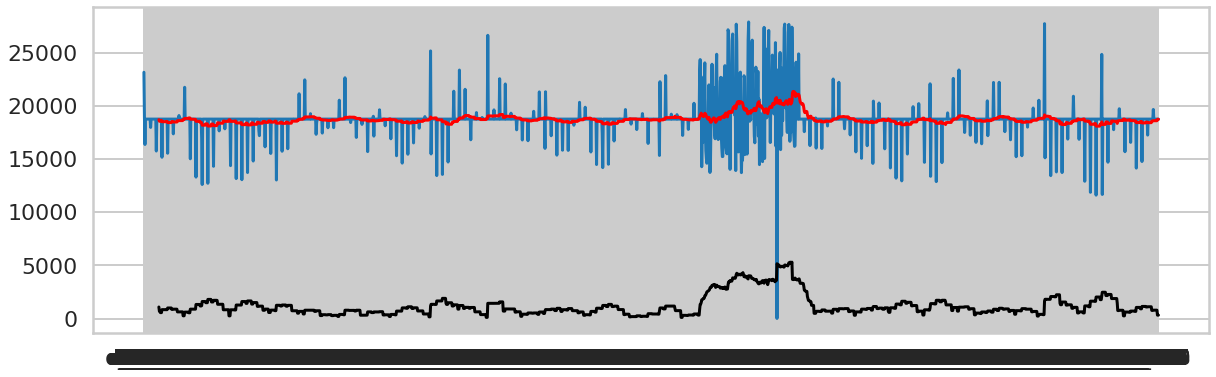

In [ ]:
#Making time series stationary
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math

def test_stationarityDF(timeseries): ##Dickey-Fuller Test
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','No of Observesations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

food_Series = total_sales_OverCalendar['FOODS']
food_Series.fillna(food_Series.mean(),inplace=True)
test_stationarityDF(food_Series)

movingAverage = food_Series.rolling(window=30).mean()
movingSTD = food_Series.rolling(window=30).std()
plt.figure(figsize=(20,6))
plt.plot(food_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

We can observe that Test Statistic is not below the 1% of the Critical value. So,Series is not stationary.

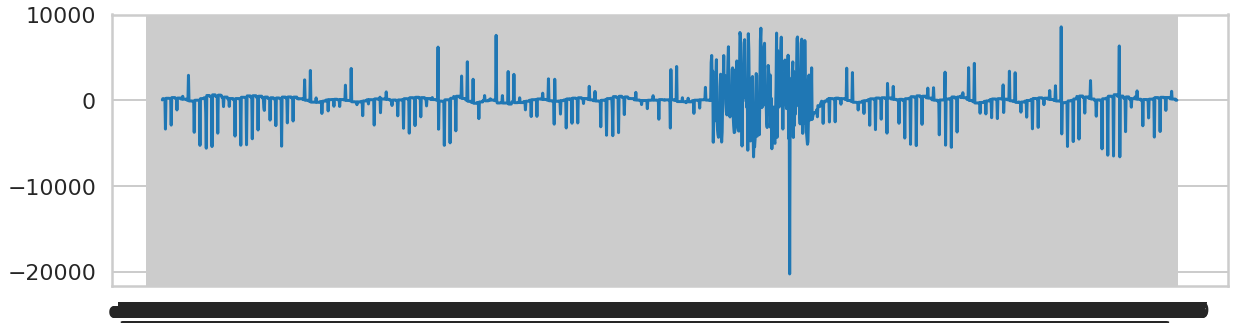

Test Statistic               -13.18903
p-value                        0.00000
#Lags Used                    24.00000
No of Observesations Used   1944.00000
Critical Value (1%)           -3.43372
Critical Value (5%)           -2.86303
Critical Value (10%)          -2.56756
dtype: float64


In [ ]:
#Make stationarry
foodSeriesDiff = food_Series-movingAverage
plt.figure(figsize=(20,5))
plt.plot(foodSeriesDiff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
foodSeriesDiff.fillna(foodSeriesDiff.mean(),inplace=True)
test_stationarityDF(foodSeriesDiff)

We can observe that Test Statistic is way less than 1% of critical value. So, we can conculde that the above Series is 99% stationary.

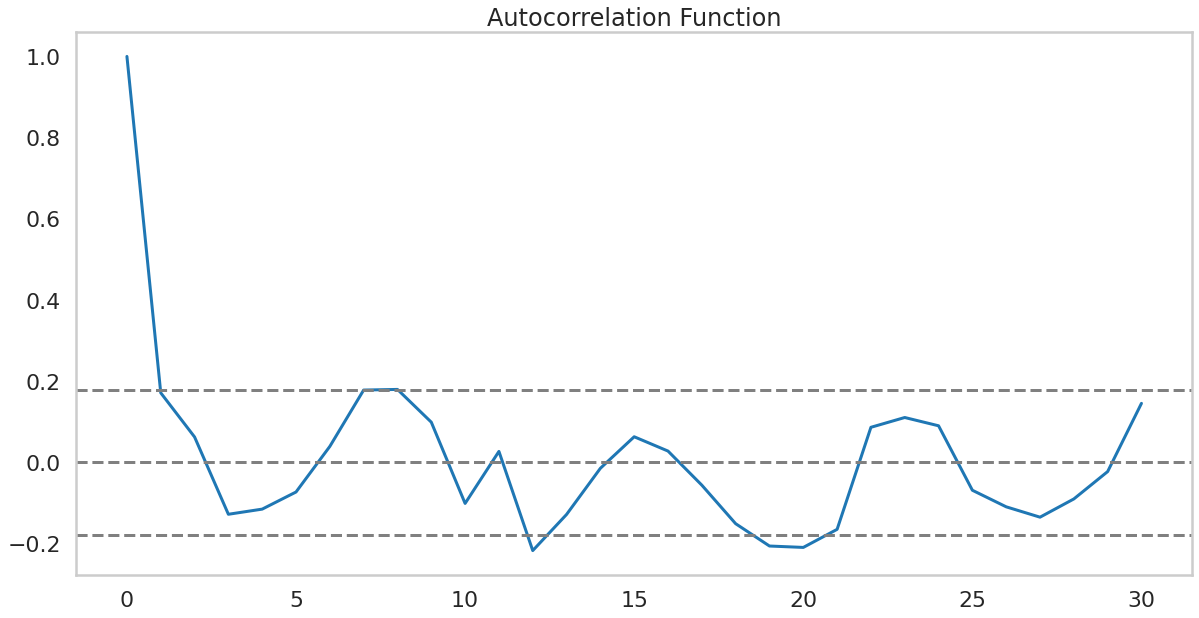

In [ ]:
plt.plot(np.arange(0,31,1),acf(foodSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.grid()
plt.show()

Correlation function cross upper confident value between 1 and 2. Hence chose 2 as p for ARIMA

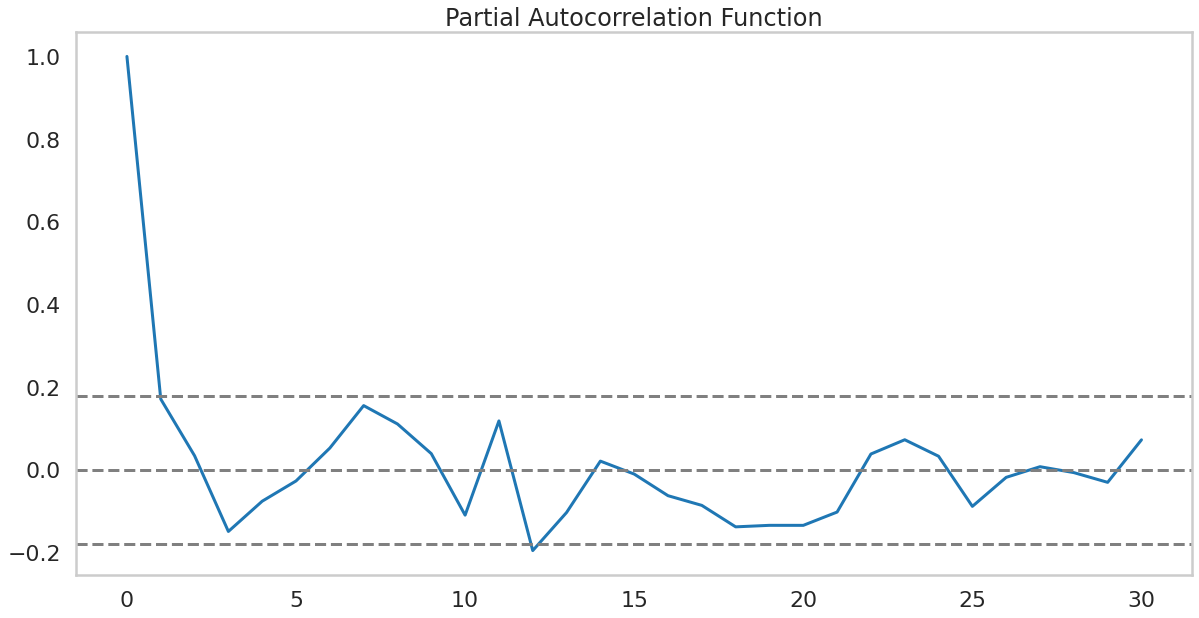

In [ ]:
plt.plot(np.arange(0,31,1),pacf(foodSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.grid()
plt.show()

Partial Autocorrelation function drop to 0 when value is between 1 and 2. choose 2 as q value

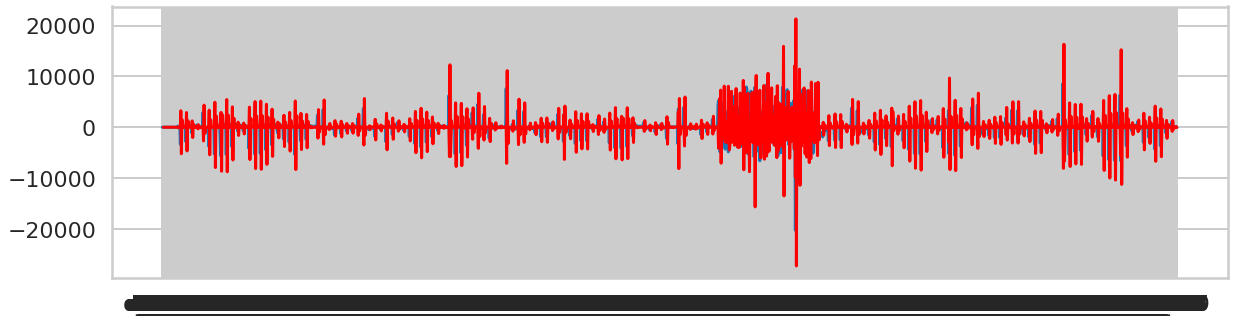

In [ ]:
model = ARIMA(foodSeriesDiff,order=(2,2,0))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,5))
plt.plot(foodSeriesDiff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.show()

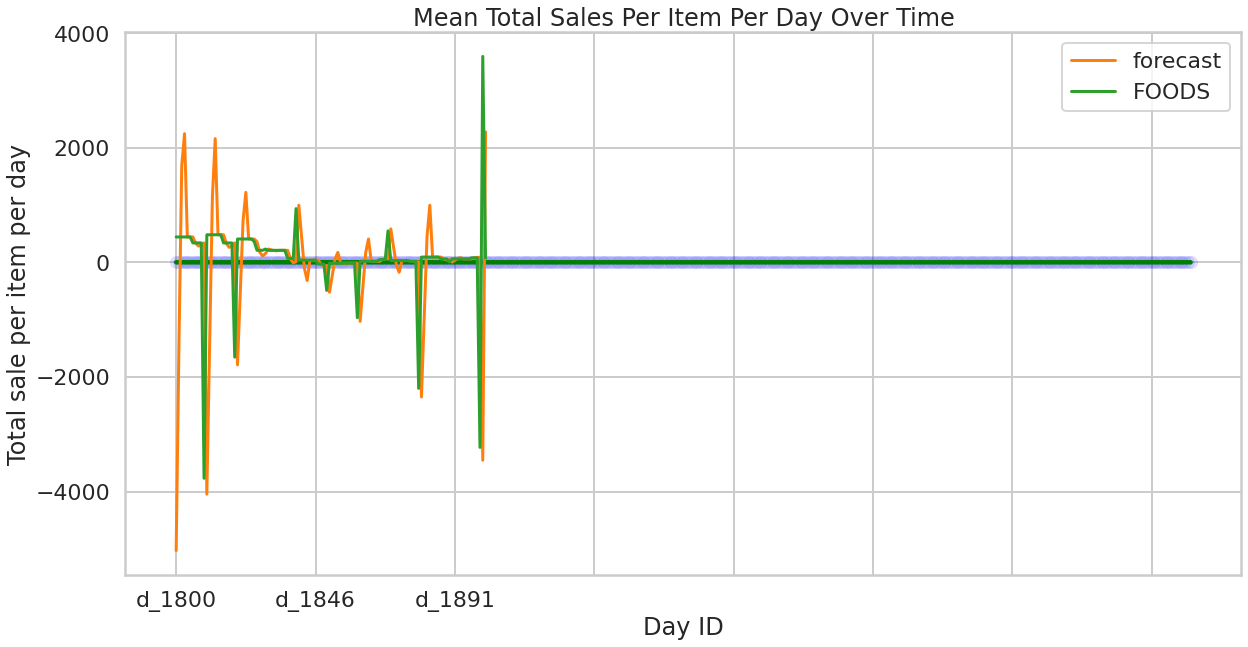

In [ ]:
results_ARIMA.plot_predict('d_1800','d_1900',dynamic=False,ax=ax)

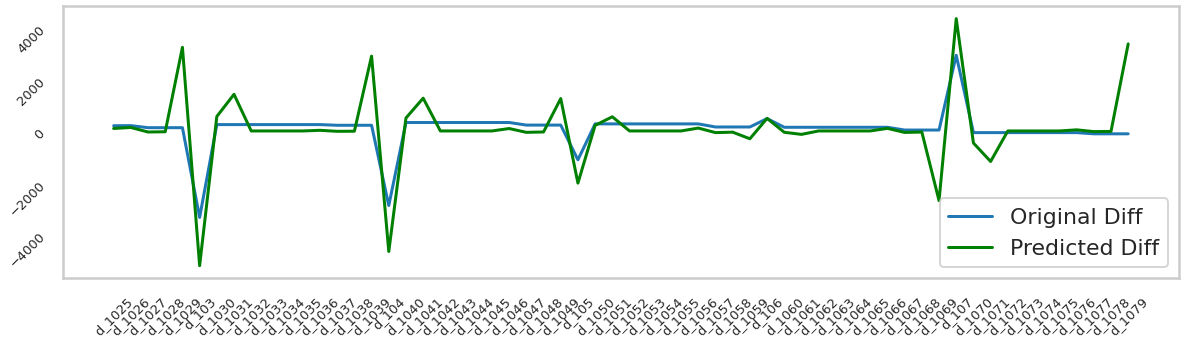

In [ ]:
#Plot a portion of data to clear visulization
plt.figure(figsize=(20,5))
ori = plt.plot(foodSeriesDiff.iloc[30:90],label='Original Diff')
#plt.plot(results_ARIMA.fittedvalues.iloc[0:60],color='red')
#plt.plot(results_ARIMA.fittedvalues.iloc[0:60].cumsum(),color='black')
##ARIMA order is 2. show results lags 2 values
#shfited['predicShfited2'] = pd.Series(results_ARIMA.fittedvalues,copy=True)
shfited = pd.DataFrame({'predicShfited2':pd.Series(results_ARIMA.fittedvalues,copy=True),'day':foodSeriesDiff.index[0:1967]})
shfited = shfited.set_index('day')
pre = plt.plot(shfited['predicShfited2'].iloc[30:90],color='green',label='Predicted Diff')
#pre = plt.plot(results_ARIMA.fittedvalues.iloc[0:60],color='green',label='Predicted Diff')
plt.legend(loc='best')
plt.grid()
plt.xticks(size = 13, rotation=45)
plt.yticks(size = 13, rotation=45)
plt.show()

Prediction

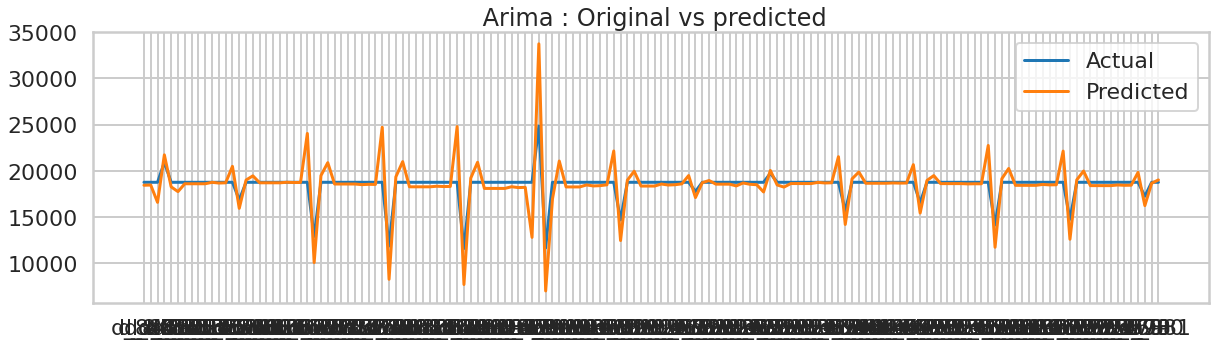

In [ ]:
predictions_ARIMA_final = pd.Series(food_Series.at['d_2'],index=food_Series.index)
shfited.loc['d_1'] = 0
shfited.loc['d_2'] = 0
movingAverage.fillna(0)
predictVsActual = pd.DataFrame({'actual':food_Series,'diffMean':foodSeriesDiff,
                                'predictDiffOri':shfited['predicShfited2'],
                                'predictDiff':shfited['predicShfited2'],
                                'base':movingAverage})
predictVsActual['predict'] = predictVsActual.loc[:,['predictDiff','base']].sum(axis=1)
predictVsActual['error'] = predictVsActual['actual'] - predictVsActual['predict']
plt.figure(figsize=(20,5))
plt.plot(predictVsActual['actual'].iloc[1800:1950],label='Actual')
plt.plot(predictVsActual['predict'].iloc[1800:1950],label='Predicted')
#plt.plot(predictVsActual[['actual','predict']])
plt.legend(loc='best')
plt.title('Original vs predicted. RMSE: %4f'%np.sqrt(sum(predictVsActual['error']**2)/len(predictVsActual)))
plt.show()

ARIMA model is based on time series values. But we have more features than the time shift effect. As a example, events, day of week, month can be considered as few more additional features.

In [ ]:
### Create a Pickle file using serialization
import pickle
pickle_out = open("model.pkl","wb")
pickle.dump(results_ARIMA, pickle_out)
pickle_out.close()